# Fall 2022: DS-GA 1011 NLP with Representation Learning
## Homework 2
## Part 2: Neural Language Modeling (30 pts)
In this assignment, you will build and analyze a neural language model with a recurrent neural network.

In [152]:
# Import required packages
import os
import json
import numpy as np
from collections import defaultdict
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from tqdm import tqdm

In [153]:
from google.colab import drive
drive.mount('/content/drive/')
%cd drive/My Drive/NLPAssignments/hw2

Drive already mounted at /content/drive/; to attempt to forcibly remount, call drive.mount("/content/drive/", force_remount=True).
[Errno 2] No such file or directory: 'drive/My Drive/NLPAssignments/hw2'
/content/drive/My Drive/NLPAssignments/hw2


---
### 1 LSTM and Hyper-parameters (10 pts)
Your first task is to train a neural recurrent language model on Wikitext-2.

#### Load data

In [154]:
def load_wikitext(filename='wikitext2-sentencized.json'):
    if not os.path.exists(filename):
        !wget "https://nyu.box.com/shared/static/9kb7l7ci30hb6uahhbssjlq0kctr5ii4.json" -O $filename
    
    datasets = json.load(open(filename, 'r'))
    for name in datasets:
        datasets[name] = [x.split() for x in datasets[name]]
    vocab = list(set([t for ts in datasets['train'] for t in ts]))      
    print("Vocab size: %d" % (len(vocab)))
    return datasets, vocab

def perplexity(model, sequences):
    n_total = 0
    logp_total = 0
    for sequence in sequences:
        logp_total += model.sequence_logp(sequence)
        n_total += len(sequence) + 1  
    ppl = 2 ** (- (1.0 / n_total) * logp_total)  
    return ppl

In [ ]:
datasets, vocab = load_wikitext()

Vocab size: 33175


#### Utilities

(Hint: you can adopt the `Dictionary`, dataset loading, `Dataloader`, `pad_collate_fn`, and training code from the lab: [**07-rnn_lm.ipynb**](https://drive.google.com/file/d/1scqLM26Njy4ACL9zyIQEVcoP32eTN77i/view?usp=sharing) for use here)

In [ ]:
class Dictionary(object): #maps words to indices
    def __init__(self, datasets, include_valid=False):
        self.tokens = []
        self.ids = {}
        self.counts = {}
        
        # add special tokens
        self.add_token('<bos>') #beginning of sentence
        self.add_token('<eos>') #end of sentence
        self.add_token('<pad>')
        self.add_token('<unk>') #unknown. Needed in case use with text with word that isn't in vocab
        
        for line in tqdm(datasets['train']):
            for w in line:
                self.add_token(w)
                    
        if include_valid is True:
            for line in tqdm(datasets['valid']):
                for w in line:
                    self.add_token(w)
                            
    def add_token(self, w):
        if w not in self.tokens:
            self.tokens.append(w)
            _w_id = len(self.tokens) - 1
            self.ids[w] = _w_id
            self.counts[w] = 1
        else:
            self.counts[w] += 1

    def get_id(self, w):
        return self.ids[w]
    
    def get_token(self, idx):
        return self.tokens[idx]
    
    def decode_idx_seq(self, l):
        return [self.tokens[i] for i in l]
    
    def encode_token_seq(self, l):
        return [self.ids[i] if i in self.ids else self.ids['<unk>'] for i in l]
    
    def __len__(self):
        return len(self.tokens)

wiki_text_dict = Dictionary(datasets, include_valid=True)

100%|██████████| 8464/8464 [00:14<00:00, 566.85it/s]


In [ ]:
def tokenize_dataset(datasets, dictionary, ngram_order=2): #substitute words with numbers. Sometimes can include splitting strings, dealing with punctuation and symbols.
    tokenized_datasets = {}
    for split, dataset in datasets.items():
        _current_dictified = []
        for l in tqdm(dataset):
            l = ['<bos>']*(ngram_order-1) + l + ['<eos>']
            encoded_l = dictionary.encode_token_seq(l)
            _current_dictified.append(encoded_l)
        tokenized_datasets[split] = _current_dictified
        
    return tokenized_datasets

In [ ]:
class TensoredDataset(Dataset):
    def __init__(self, list_of_lists_of_tokens):
        self.input_tensors = []
        self.target_tensors = []
        
        for sample in list_of_lists_of_tokens:
            self.input_tensors.append(torch.tensor([sample[:-1]], dtype=torch.long))
            self.target_tensors.append(torch.tensor([sample[1:]], dtype=torch.long))
    
    def __len__(self):
        return len(self.input_tensors)
    
    def __getitem__(self, idx):
        # return a (input, target) tuple
        return (self.input_tensors[idx], self.target_tensors[idx])

In [ ]:
wikitext_tokenized_datasets = tokenize_dataset(datasets, wiki_text_dict)
wiki_tensor_dataset = {}

for split, listoflists in wikitext_tokenized_datasets.items():
    wiki_tensor_dataset[split] = TensoredDataset(listoflists)

100%|██████████| 9708/9708 [00:00<00:00, 118855.02it/s]


In [ ]:
def pad_list_of_tensors(list_of_tensors, pad_token):
    max_length = max([t.size(-1) for t in list_of_tensors])
    padded_list = []
    
    for t in list_of_tensors:
        padded_tensor = torch.cat([t, torch.tensor([[pad_token]*(max_length - t.size(-1))], dtype=torch.long)], dim = -1)
        padded_list.append(padded_tensor)
        
    padded_tensor = torch.cat(padded_list, dim=0)
    
    return padded_tensor

def pad_collate_fn(batch):
    # batch is a list of sample tuples
    input_list = [s[0] for s in batch]
    target_list = [s[1] for s in batch]
    
    pad_token = wiki_text_dict.get_id('<pad>')
    #pad_token = 2
    
    input_tensor = pad_list_of_tensors(input_list, pad_token)
    target_tensor = pad_list_of_tensors(target_list, pad_token)
    
    return input_tensor, target_tensor

In [ ]:
wiki_loaders = {}

batch_size = 64

for split, wiki_dataset in wiki_tensor_dataset.items():
    wiki_loaders[split] = DataLoader(wiki_dataset, batch_size=batch_size, shuffle=True, collate_fn=pad_collate_fn)

In [ ]:
num_gpus = torch.cuda.device_count()
if num_gpus > 0:
    current_device = 'cuda'
else:
    current_device = 'cpu'

#### Model + Training (5 pts)

In [ ]:
class LSTMLanguageModel(nn.Module):
    """
    This model combines embedding, rnn and projection layer into a single model
    """
    def __init__(self, options):
        super().__init__()
        
        # create each LM part here 
    
        self.lookup = nn.Embedding(num_embeddings=options['num_embeddings'], embedding_dim=options['embedding_dim'], padding_idx=options['padding_idx'])
      
        self.rnn_lstm = nn.LSTM(input_size=options['input_size'], hidden_size=options['hidden_size'],num_layers=options['num_layers'],dropout=options['rnn_dropout'], batch_first=True)
        
        self.projection = nn.Linear(options['hidden_size'], options['num_embeddings'])
    
    def forward(self, encoded_input_sequence):
        """
        Forward method process the input from token ids to logits
        """
        embeddings = self.lookup(encoded_input_sequence)
  
        rnn_outputs,output_hidden_state = self.rnn_lstm(embeddings)
        
        logits = self.projection(rnn_outputs)
        
        return logits,output_hidden_state
    
    def sequence_logp(self, sequence):
        logits,hidden_state = self.forward(sequence)
        return F.log_softmax(logits)

In [ ]:
# Setting Parameters
embedding_size = 256
hidden_size = 512
num_layers = 3
rnn_dropout = 0.3

options = {
    'num_embeddings': len(wiki_text_dict),
    'embedding_dim': embedding_size,
    'padding_idx': wiki_text_dict.get_id('<pad>'),
    'input_size': embedding_size,
    'hidden_size': hidden_size,
    'num_layers': num_layers,
    'rnn_dropout': rnn_dropout,
    }

    
model = LSTMLanguageModel(options).to(current_device)

criterion = nn.CrossEntropyLoss(ignore_index=wiki_text_dict.get_id('<pad>'))

model_parameters = [p for p in model.parameters() if p.requires_grad]
optimizer = optim.SGD(model_parameters, lr=0.001, momentum=0.999)

In [ ]:
# Training Loop
plot_cache = []

max_patience = 4 # Max patience hyperparameter
val_epoch_loss = []
train_epoch_loss = []
terminate_loop_ctr = 0
epochs = 20
  
for epoch_number in range(epochs):
    avg_loss=0
    # do train
    model.train()
    train_log_cache = []
    for i, (inp, target) in tqdm(enumerate(wiki_loaders['train'])):
      optimizer.zero_grad()
      inp = inp.to(current_device)
      target = target.to(current_device)
      logits,hidden_state = model(inp)
        
      loss = criterion(logits.view(-1, logits.size(-1)), target.view(-1))
            
      loss.backward()
      optimizer.step()
            
      train_log_cache.append(loss.item())
    
    avg_train_loss = sum(train_log_cache)/len(train_log_cache)
    print('Training loss after {} epoch = {:.{prec}f}'.format(epoch_number+1, avg_train_loss, prec=4))
    train_epoch_loss.append(avg_train_loss)
    
    #do valid
    valid_losses = []
    model.eval()
    with torch.no_grad():
        for i, (inp, target) in tqdm(enumerate(wiki_loaders['valid'])):
          inp = inp.to(current_device)
          target = target.to(current_device)
          logits,hidden_state = model(inp)

          loss = criterion(logits.view(-1, logits.size(-1)), target.view(-1))
          valid_losses.append(loss.item())
        
        avg_val_loss = sum(valid_losses) / len(valid_losses)
        print('Validation loss after {} epoch = {:.{prec}f}'.format(epoch_number+1, avg_val_loss, prec=4))
        val_epoch_loss.append(avg_val_loss)
        

    # Implementing Validation based Early Stopping 
    if (epoch_number>=1 and round(val_epoch_loss[-1],2)==round(val_epoch_loss[-2],2)):
      terminate_loop_ctr+=1
    else:
      terminate_loop_ctr=0
      
    # Break Training Loop
    if (terminate_loop_ctr==max_patience):
      plot_cache.append((avg_loss,max(val_epoch_loss))) # Saving best validation loss
      print ("Max Patience Reached, Implementing Validation based early stopping.")
      break
    
    plot_cache.append((avg_loss, avg_val_loss))

# Saving Model
torch.save({
    'options': options,
    'loss_cache': plot_cache,
    'train_loss':train_epoch_loss,
    'val_loss':val_epoch_loss,
    'model_dict': model.state_dict()
    },'./saved_models/wiki_lstm_lr='+str(options['rnn_dropout'])+'_lm.pt')

1224it [03:30,  5.80it/s]


Training loss after 1 epoch = 8.4731


133it [00:08, 15.71it/s]


Validation loss after 1 epoch = 7.4828


1224it [03:43,  5.48it/s]


Training loss after 2 epoch = 7.3279


133it [00:08, 15.11it/s]


Validation loss after 2 epoch = 6.9036


1224it [03:42,  5.50it/s]


Training loss after 3 epoch = 6.8808


133it [00:08, 15.07it/s]


Validation loss after 3 epoch = 6.5510


1224it [03:43,  5.47it/s]


Training loss after 4 epoch = 6.6054


133it [00:08, 15.09it/s]


Validation loss after 4 epoch = 6.3178


1224it [03:44,  5.46it/s]


Training loss after 5 epoch = 6.4138


133it [00:08, 15.02it/s]


Validation loss after 5 epoch = 6.1544


1224it [03:44,  5.46it/s]


Training loss after 6 epoch = 6.2592


133it [00:08, 14.96it/s]


Validation loss after 6 epoch = 6.0135


1224it [03:44,  5.46it/s]


Training loss after 7 epoch = 6.1221


133it [00:08, 15.02it/s]


Validation loss after 7 epoch = 5.8871


1224it [03:45,  5.43it/s]


Training loss after 8 epoch = 6.0030


133it [00:08, 15.10it/s]


Validation loss after 8 epoch = 5.7911


1224it [03:45,  5.44it/s]


Training loss after 9 epoch = 5.8997


133it [00:08, 14.91it/s]


Validation loss after 9 epoch = 5.7038


1224it [03:44,  5.45it/s]


Training loss after 10 epoch = 5.8105


133it [00:08, 14.78it/s]


Validation loss after 10 epoch = 5.6343


1224it [03:45,  5.44it/s]


Training loss after 11 epoch = 5.7295


133it [00:08, 14.88it/s]


Validation loss after 11 epoch = 5.5700


1224it [03:43,  5.47it/s]


Training loss after 12 epoch = 5.6571


133it [00:08, 15.03it/s]


Validation loss after 12 epoch = 5.5185


1224it [03:44,  5.46it/s]


Training loss after 13 epoch = 5.5900


133it [00:08, 14.84it/s]


Validation loss after 13 epoch = 5.4676


1224it [03:43,  5.47it/s]


Training loss after 14 epoch = 5.5251


133it [00:08, 15.03it/s]


Validation loss after 14 epoch = 5.4190


1224it [03:43,  5.47it/s]


Training loss after 15 epoch = 5.4671


133it [00:08, 14.83it/s]


Validation loss after 15 epoch = 5.3821


1224it [03:44,  5.45it/s]


Training loss after 16 epoch = 5.4106


133it [00:08, 14.90it/s]


Validation loss after 16 epoch = 5.3421


1224it [03:44,  5.46it/s]


Training loss after 17 epoch = 5.3595


133it [00:08, 14.90it/s]


Validation loss after 17 epoch = 5.3225


1224it [03:44,  5.46it/s]


Training loss after 18 epoch = 5.3092


133it [00:09, 14.76it/s]


Validation loss after 18 epoch = 5.2812


1224it [03:43,  5.47it/s]


Training loss after 19 epoch = 5.2615


133it [00:08, 14.91it/s]


Validation loss after 19 epoch = 5.2496


1224it [03:44,  5.44it/s]


Training loss after 20 epoch = 5.2177


133it [00:08, 14.81it/s]


Validation loss after 20 epoch = 5.2304


In [239]:
def plot_curves(training_loss,validation_loss,epochs):
  epoch_list = list(range(epochs))
  plt.subplot(1,2,1)
  plt.title('Epochs vs Training Loss')
  plt.plot(epoch_list, training_loss, 'b')
  plt.ylabel('Training Loss')
  plt.xlabel('Number of Epochs')
  plt.subplot(1,2,2)
  plt.title('Epochs vs Validation Loss')
  plt.plot(epoch_list, validation_loss, 'r')
  plt.ylabel('Validation Loss')
  plt.xlabel('Number of Epochs')
  
  plt.suptitle("Loss Curves")
  plt.show()

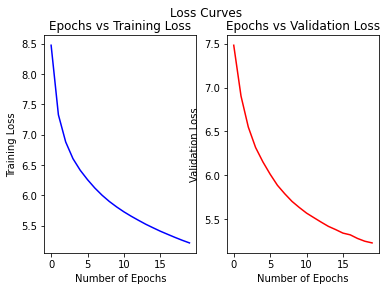

In [243]:
plot_curves(train_epoch_loss,val_epoch_loss,20)

#### Performance variation based on hyper-parameter values (5 pts)


In [ ]:
def train(model):
  # Training Loop
  plot_cache = []

  max_patience = 4 # Max patience hyperparameter
  val_epoch_loss = []
  train_epoch_loss = []
  train_batch_losses = []
  terminate_loop_ctr = 0
  epochs = 20
    
  for epoch_number in range(epochs):
      avg_loss=0
      # do train
      model.train()
      train_log_cache = []
      for i, (inp, target) in tqdm(enumerate(wiki_loaders['train'])):
        optimizer.zero_grad()
        inp = inp.to(current_device)
        target = target.to(current_device)
        logits,hidden_state = model(inp)
          
        loss = criterion(logits.view(-1, logits.size(-1)), target.view(-1))
              
        loss.backward()
        optimizer.step()
              
        train_log_cache.append(loss.item())
      
      avg_train_loss = sum(train_log_cache) / len(train_log_cache)
      print('Training loss after {} epoch = {:.{prec}f}'.format(epoch_number+1, avg_train_loss, prec=4))
      train_epoch_loss.append(avg_train_loss)    
      
      #do valid
      valid_losses = []
      model.eval()
      with torch.no_grad():
          for i, (inp, target) in tqdm(enumerate(wiki_loaders['valid'])):
            inp = inp.to(current_device)
            target = target.to(current_device)
            logits,hidden_state = model(inp)

            loss = criterion(logits.view(-1, logits.size(-1)), target.view(-1))
            valid_losses.append(loss.item())
          
          avg_val_loss = sum(valid_losses) / len(valid_losses)
          print('Validation loss after {} epoch = {:.{prec}f}'.format(epoch_number+1, avg_val_loss, prec=4))
          val_epoch_loss.append(avg_val_loss)

      # Implementing Validation based Early Stopping 
      if (epoch_number>=1 and round(val_epoch_loss[-1],2)==round(val_epoch_loss[-2],2)):
        terminate_loop_ctr+=1
      else:
        terminate_loop_ctr=0
      
      # Break Training Loop
      if (terminate_loop_ctr==max_patience):
        plot_cache.append((avg_loss,max(val_epoch_loss))) # Saving best validation loss
        print ("Max Patience Reached, Implementing Validation based early stopping.")
        break
      
      plot_cache.append((avg_loss, avg_val_loss))

  return train_epoch_loss,val_epoch_loss,plot_cache

In [ ]:
dropouts = [0.2,0.4,0.5] # Tuning dropout value

# Setting Parameters
embedding_size = 256
hidden_size = 512
num_layers = 3

lstm_options = {
    'num_embeddings': len(wiki_text_dict),
    'embedding_dim': embedding_size,
    'padding_idx': wiki_text_dict.get_id('<pad>'),
    'input_size': embedding_size,
    'hidden_size': hidden_size,
    'num_layers': num_layers,
    }

In [ ]:
options1 = lstm_options
options1['rnn_dropout'] = dropouts[0]
model1 = LSTMLanguageModel(options1).to(current_device)

model_parameters = [p for p in model1.parameters() if p.requires_grad]
optimizer = optim.SGD(model_parameters, lr=0.001, momentum=0.999)

train_loss,val_loss,plot_cache = train(model1)

# Saving Model
torch.save({
    'options': options1,
    'loss_cache': plot_cache,
    'train_loss':train_loss,
    'val_loss':val_loss,
    'model_dict': model1.state_dict()
    },'./saved_models/wiki_lstm_lr'+str(dropouts[0])+'_lm.pt')

1224it [03:39,  5.57it/s]


Training loss after 1 epoch = 8.4870


133it [00:08, 15.64it/s]


Validation loss after 1 epoch = 7.4776


1224it [03:44,  5.45it/s]


Training loss after 2 epoch = 7.3237


133it [00:08, 15.53it/s]


Validation loss after 2 epoch = 6.8977


1224it [03:45,  5.43it/s]


Training loss after 3 epoch = 6.8718


133it [00:08, 15.48it/s]


Validation loss after 3 epoch = 6.5395


1224it [03:45,  5.43it/s]


Training loss after 4 epoch = 6.5911


133it [00:08, 15.59it/s]


Validation loss after 4 epoch = 6.2999


1224it [03:44,  5.45it/s]


Training loss after 5 epoch = 6.3919


133it [00:08, 15.73it/s]


Validation loss after 5 epoch = 6.1357


1224it [03:44,  5.45it/s]


Training loss after 6 epoch = 6.2312


133it [00:08, 15.53it/s]


Validation loss after 6 epoch = 5.9828


1224it [03:45,  5.42it/s]


Training loss after 7 epoch = 6.0854


133it [00:08, 15.40it/s]


Validation loss after 7 epoch = 5.8539


1224it [03:45,  5.44it/s]


Training loss after 8 epoch = 5.9585


133it [00:08, 15.58it/s]


Validation loss after 8 epoch = 5.7564


1224it [03:44,  5.46it/s]


Training loss after 9 epoch = 5.8487


133it [00:08, 15.47it/s]


Validation loss after 9 epoch = 5.6650


1224it [03:44,  5.44it/s]


Training loss after 10 epoch = 5.7522


133it [00:08, 15.43it/s]


Validation loss after 10 epoch = 5.5919


1224it [03:46,  5.41it/s]


Training loss after 11 epoch = 5.6681


133it [00:08, 15.39it/s]


Validation loss after 11 epoch = 5.5349


1224it [03:44,  5.45it/s]


Training loss after 12 epoch = 5.5916


133it [00:08, 15.51it/s]


Validation loss after 12 epoch = 5.4743


1224it [03:44,  5.44it/s]


Training loss after 13 epoch = 5.5214


133it [00:08, 15.28it/s]


Validation loss after 13 epoch = 5.4395


1224it [03:44,  5.45it/s]


Training loss after 14 epoch = 5.4554


133it [00:08, 15.33it/s]


Validation loss after 14 epoch = 5.3800


1224it [03:45,  5.44it/s]


Training loss after 15 epoch = 5.3926


133it [00:08, 15.36it/s]


Validation loss after 15 epoch = 5.3472


1224it [03:45,  5.42it/s]


Training loss after 16 epoch = 5.3331


133it [00:08, 15.35it/s]


Validation loss after 16 epoch = 5.3111


1224it [03:44,  5.44it/s]


Training loss after 17 epoch = 5.2794


133it [00:08, 15.33it/s]


Validation loss after 17 epoch = 5.2829


1224it [03:45,  5.43it/s]


Training loss after 18 epoch = 5.2265


133it [00:08, 15.21it/s]


Validation loss after 18 epoch = 5.2500


1224it [03:44,  5.44it/s]


Training loss after 19 epoch = 5.1767


133it [00:08, 15.25it/s]


Validation loss after 19 epoch = 5.2341


1224it [03:44,  5.45it/s]


Training loss after 20 epoch = 5.1305


133it [00:08, 15.39it/s]


Validation loss after 20 epoch = 5.2102


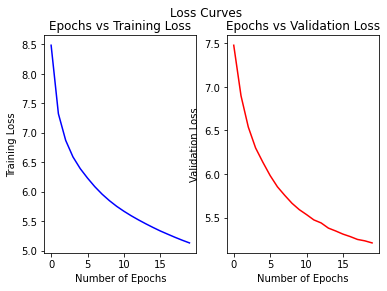

In [ ]:
plot_curves(train_loss,val_loss,20)

In [ ]:
options2 = lstm_options
options2['rnn_dropout'] = dropouts[1]
model2 = LSTMLanguageModel(options2).to(current_device)

model_parameters = [p for p in model2.parameters() if p.requires_grad]
optimizer = optim.SGD(model_parameters, lr=0.001, momentum=0.999)

train_loss,val_loss,plot_cache = train(model2)

# Saving Model
torch.save({
    'options': options2,
    'loss_cache': plot_cache,
    'train_loss':train_loss,
    'val_loss':val_loss,
    'model_dict': model2.state_dict()
    },'./saved_models/wiki_lstm_lr'+str(dropouts[1])+'_lm.pt')

1224it [03:44,  5.45it/s]


Training loss after 1 epoch = 8.4721


133it [00:08, 15.56it/s]


Validation loss after 1 epoch = 7.4922


1224it [03:45,  5.44it/s]


Training loss after 2 epoch = 7.3256


133it [00:08, 15.69it/s]


Validation loss after 2 epoch = 6.8949


1224it [03:43,  5.47it/s]


Training loss after 3 epoch = 6.8763


133it [00:08, 15.67it/s]


Validation loss after 3 epoch = 6.5466


1224it [03:43,  5.47it/s]


Training loss after 4 epoch = 6.6082


133it [00:08, 15.50it/s]


Validation loss after 4 epoch = 6.3204


1224it [03:43,  5.47it/s]


Training loss after 5 epoch = 6.4192


133it [00:08, 15.58it/s]


Validation loss after 5 epoch = 6.1503


1224it [03:44,  5.45it/s]


Training loss after 6 epoch = 6.2669


133it [00:08, 15.50it/s]


Validation loss after 6 epoch = 6.0151


1224it [03:44,  5.45it/s]


Training loss after 7 epoch = 6.1324


133it [00:08, 15.57it/s]


Validation loss after 7 epoch = 5.8950


1224it [03:45,  5.44it/s]


Training loss after 8 epoch = 6.0160


133it [00:08, 15.54it/s]


Validation loss after 8 epoch = 5.7890


1224it [03:44,  5.45it/s]


Training loss after 9 epoch = 5.9165


133it [00:08, 15.51it/s]


Validation loss after 9 epoch = 5.7145


1224it [03:44,  5.45it/s]


Training loss after 10 epoch = 5.8295


133it [00:08, 15.37it/s]


Validation loss after 10 epoch = 5.6392


1224it [03:44,  5.45it/s]


Training loss after 11 epoch = 5.7522


133it [00:08, 15.35it/s]


Validation loss after 11 epoch = 5.5821


1224it [03:45,  5.43it/s]


Training loss after 12 epoch = 5.6842


133it [00:08, 15.32it/s]


Validation loss after 12 epoch = 5.5337


1224it [03:45,  5.44it/s]


Training loss after 13 epoch = 5.6197


133it [00:08, 15.40it/s]


Validation loss after 13 epoch = 5.4874


1224it [03:45,  5.44it/s]


Training loss after 14 epoch = 5.5625


133it [00:08, 15.27it/s]


Validation loss after 14 epoch = 5.4429


1224it [03:45,  5.42it/s]


Training loss after 15 epoch = 5.5084


133it [00:08, 15.31it/s]


Validation loss after 15 epoch = 5.4107


1224it [03:45,  5.43it/s]


Training loss after 16 epoch = 5.4584


133it [00:08, 15.22it/s]


Validation loss after 16 epoch = 5.3700


1224it [03:46,  5.41it/s]


Training loss after 17 epoch = 5.4128


133it [00:08, 15.19it/s]


Validation loss after 17 epoch = 5.3400


1224it [03:44,  5.44it/s]


Training loss after 18 epoch = 5.3685


133it [00:08, 15.14it/s]


Validation loss after 18 epoch = 5.3066


1224it [03:45,  5.44it/s]


Training loss after 19 epoch = 5.3280


133it [00:08, 15.44it/s]


Validation loss after 19 epoch = 5.2970


1224it [03:45,  5.42it/s]


Training loss after 20 epoch = 5.2895


133it [00:08, 15.38it/s]


Validation loss after 20 epoch = 5.2676


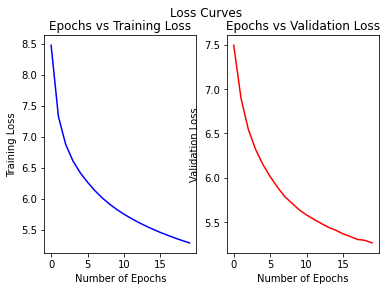

In [240]:
plot_curves(train_loss,val_loss,20)

In [ ]:
options3 = lstm_options
options3['rnn_dropout'] = dropouts[2]

model3 = LSTMLanguageModel(options3).to(current_device)

model_parameters = [p for p in model3.parameters() if p.requires_grad]
optimizer = optim.SGD(model_parameters, lr=0.001, momentum=0.999)

train_loss,val_loss,plot_cache = train(model3)

# Saving Model
torch.save({
    'options': options3,
    'loss_cache': plot_cache,
    'train_loss':train_loss,
    'val_loss':val_loss,
    'model_dict': model3.state_dict()
    },'./saved_models/wiki_lstm_lr'+str(dropouts[2])+'_lm.pt')

1224it [03:30,  5.83it/s]


Training loss after 1 epoch = 8.4689


133it [00:07, 16.63it/s]


Validation loss after 1 epoch = 7.4914


1224it [03:29,  5.84it/s]


Training loss after 2 epoch = 7.3336


133it [00:08, 16.33it/s]


Validation loss after 2 epoch = 6.8952


1224it [03:30,  5.82it/s]


Training loss after 3 epoch = 6.8741


133it [00:08, 16.39it/s]


Validation loss after 3 epoch = 6.5419


1224it [03:30,  5.81it/s]


Training loss after 4 epoch = 6.6080


133it [00:08, 16.51it/s]


Validation loss after 4 epoch = 6.3248


1224it [03:30,  5.81it/s]


Training loss after 5 epoch = 6.4248


133it [00:08, 16.28it/s]


Validation loss after 5 epoch = 6.1593


1224it [03:30,  5.82it/s]


Training loss after 6 epoch = 6.2803


133it [00:08, 16.33it/s]


Validation loss after 6 epoch = 6.0335


1224it [03:30,  5.81it/s]


Training loss after 7 epoch = 6.1570


133it [00:08, 16.48it/s]


Validation loss after 7 epoch = 5.9206


1224it [03:29,  5.83it/s]


Training loss after 8 epoch = 6.0506


133it [00:08, 16.44it/s]


Validation loss after 8 epoch = 5.8301


1224it [03:31,  5.80it/s]


Training loss after 9 epoch = 5.9583


133it [00:08, 16.30it/s]


Validation loss after 9 epoch = 5.7489


1224it [03:30,  5.81it/s]


Training loss after 10 epoch = 5.8781


133it [00:08, 16.28it/s]


Validation loss after 10 epoch = 5.6804


1224it [03:30,  5.81it/s]


Training loss after 11 epoch = 5.8056


133it [00:08, 16.32it/s]


Validation loss after 11 epoch = 5.6229


1224it [03:31,  5.80it/s]


Training loss after 12 epoch = 5.7408


133it [00:08, 16.34it/s]


Validation loss after 12 epoch = 5.5750


1224it [03:31,  5.80it/s]


Training loss after 13 epoch = 5.6824


133it [00:08, 16.11it/s]


Validation loss after 13 epoch = 5.5274


1224it [03:31,  5.78it/s]


Training loss after 14 epoch = 5.6274


133it [00:08, 16.12it/s]


Validation loss after 14 epoch = 5.4872


1224it [03:31,  5.80it/s]


Training loss after 15 epoch = 5.5763


133it [00:08, 16.28it/s]


Validation loss after 15 epoch = 5.4419


1224it [03:30,  5.82it/s]


Training loss after 16 epoch = 5.5273


133it [00:08, 16.29it/s]


Validation loss after 16 epoch = 5.4122


1224it [03:31,  5.79it/s]


Training loss after 17 epoch = 5.4798


133it [00:08, 16.08it/s]


Validation loss after 17 epoch = 5.3813


1224it [03:30,  5.82it/s]


Training loss after 18 epoch = 5.4377


133it [00:08, 16.19it/s]


Validation loss after 18 epoch = 5.3593


1224it [03:31,  5.78it/s]


Training loss after 19 epoch = 5.3962


133it [00:08, 16.23it/s]


Validation loss after 19 epoch = 5.3223


1224it [03:31,  5.79it/s]


Training loss after 20 epoch = 5.3563


133it [00:08, 16.17it/s]


Validation loss after 20 epoch = 5.2960


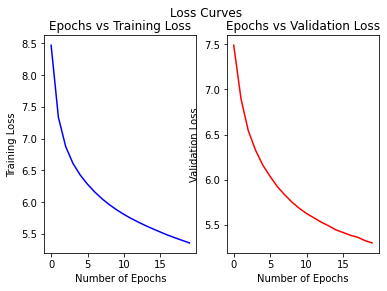

In [ ]:
plot_curves(train_loss,val_loss,20)

---
### 2 Learned embeddings (6 pts)
Next you will analyze the word embeddings that the model learns.


#### Utilities

Below is code to use [UMAP](https://umap-learn.readthedocs.io/en/latest/) to find a 2-dimensional representation of a weight matrix, and plot the resulting 2-dimensional points that correspond to certain words.

Use `!pip install umap-learn` to install UMAP.

In [ ]:
!pip install umap-learn

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 88 kB 4.1 MB/s 
     |████████████████████████████████| 1.1 MB 16.9 MB/s 
  Created wheel for umap-learn: filename=umap_learn-0.5.3-py3-none-any.whl size=82829 sha256=63f2b73ed6732e3e240bad412e9b362fcca8048c62eb9af5aaaec6d7d7f0d448
  Stored in directory: /root/.cache/pip/wheels/b3/52/a5/1fd9e3e76a7ab34f134c07469cd6f16e27ef3a37aeff1fe821
  Created wheel for pynndescent: filename=pynndescent-0.5.8-py3-none-any.whl size=55512 sha256=4a938646dafb9369d5434b38acea33bb6f7d35d136f7180795ddad2c131dd0ab
  Stored in directory: /root/.cache/pip/wheels/19/bc/eb/974072a56a7082a302f8b4be1ad6d21bf5019235c2eff65928
Successfully built umap-learn pynndescent


In [ ]:
%pylab inline 
import umap
import matplotlib.pyplot as plt

def umap_plot(weight_matrix, word_ids, words):
    """Run UMAP on the entire Vxd `weight_matrix` (e.g. model.lookup.weight or model.projection.weight),
    And plot the points corresponding to the given `word_ids`. """
    reduced = umap.UMAP(min_dist=0.0001).fit_transform(weight_matrix.detach().cpu().numpy())
    plt.figure(figsize=(10,10))

    to_plot = reduced[word_ids, :]
    plt.scatter(to_plot[:, 0], to_plot[:, 1])
    for i, word_id in enumerate(word_ids):
        current_point = to_plot[i]
        plt.annotate(words[i], (current_point[0], current_point[1]))

    plt.grid()
    plt.show()

Populating the interactive namespace from numpy and matplotlib


/usr/local/lib/python3.7/dist-packages/IPython/core/magics/pylab.py:160: UserWarning: pylab import has clobbered these variables: ['split']
`%matplotlib` prevents importing * from pylab and numpy
  "\n`%matplotlib` prevents importing * from pylab and numpy"


In [244]:
best_lstm_model = torch.load('./saved_models/best_lstm_model',map_location=current_device)
lstm_model_dict = torch.load('./saved_models/wiki_lstm_lr=0.3_lm.pt',map_location=current_device)

#### 2.1 Word similarity (3 pts)


In [230]:
from collections import defaultdict
words = ["the","run","dog","where"]
weight_matrix = lstm_model_dict['model_dict']['projection.weight'] 

# Cosing Similarity between 2 tensors
def cosine_similarity(word1_tensor,word2_tensor):
  dot_product = torch.dot(word1_tensor,word2_tensor)
  cross_product = torch.mul(torch.linalg.norm(word1_tensor),torch.linalg.norm(word2_tensor))
  return torch.div(dot_product,cross_product)

"""
Testing cosine similarity function
word1_tensor = torch.tensor([3,2,0,5],dtype=float)
word2_tensor = torch.tensor([1,0,0,0],dtype=float)
print (cosine_similarity(word1_tensor,word2_tensor))
"""

closest_words_list = []
farthest_words_list = []

for word in words:
  word_id = wiki_text_dict.get_id(word)
  word_tensor = weight_matrix[word_id].to(float)
  
  cosine_matrix = []
  for k in weight_matrix.tolist():
    cosine_matrix.append(cosine_similarity(torch.tensor(k,dtype=float),word_tensor))
  
  cosine_tensor = torch.tensor(cosine_matrix,dtype=float)
  closest_words = torch.topk(cosine_tensor, 11).indices
  farthest_words = torch.topk(cosine_tensor,10,largest=False).indices
  print (wiki_text_dict.decode_idx_seq(closest_words.tolist()[1:])) # Ignoring first word since it would already be there
  print (wiki_text_dict.decode_idx_seq(farthest_words.tolist()))
  closest_words_list.extend(wiki_text_dict.decode_idx_seq(closest_words.tolist()[1:]))
  farthest_words_list.extend(wiki_text_dict.decode_idx_seq(farthest_words.tolist()))

words.extend(closest_words_list)
words.extend(farthest_words_list)

['a', 'Konami', 'sonate', 'Islington', '153', 'Romanticism', 'Psyche', 'sabotage', 'reissued', 'Algiers']
['or', ';', '–', 'first', "'", '/', '@.@', 'city', 'film', 'but']
['match', 'win', 'set', 'pass', 'defeat', 'record', 'play', 'return', 'campaign', 'lead']
['Rashid', 'Kingston', "'Italia", 'Corners', 'Carrier', 'Applause', 'Canis', 'Buteo', 'Tamba', 'Torre']
['voice', 'concept', 'phrase', 'plot', 'poem', 'fox', 'narrative', 'wedding', 'baby', 'depiction']
['1916', 'dissipating', 'UTC', '1941', '1915', '1914', '1931', '1918', '1936', 'el']
['when', 'but', 'before', 'who', 'while', 'during', 'between', 'which', 'after', 'under']
['the', 'Sejm', 'popularisation', 'untimely', 'cellist', 'marksman', 'wrists', 'Poison', 'lifesize', 'Pr']


#### 2.2 UMAP (3 pts)

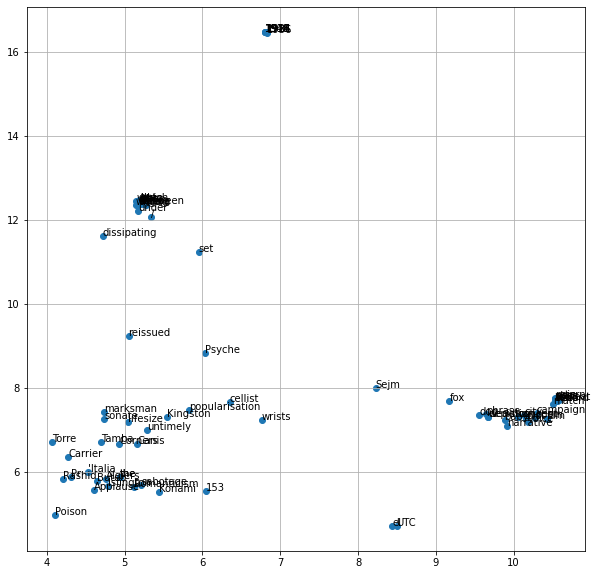

In [233]:
Vsize = len(wiki_text_dict)                                     # e.g. len(dictionary)
d = lstm_model_dict['model_dict']['projection.weight'].size(1)       # e.g. model.lookup.weight.size(1) 
weight_matrix = lstm_model_dict['model_dict']['projection.weight']   # e.g. model.lookup.weight

word_ids = [wiki_text_dict.get_id(word) for word in words]

umap_plot(weight_matrix, word_ids, words)

---
### 3 Sampling (14 pts)


#### 3.1 Sampling implementation (4 pts)

In [245]:
def sampling(model):
  h0 = torch.zeros(3,512,device=current_device)
  c0 = torch.zeros(3,512,device=current_device)
  sample_sequence = ['<bos>']
  xt_plus = torch.tensor(wiki_text_dict.encode_token_seq(sample_sequence),device=current_device)

  while sample_sequence[-1]!='<eos>':
    state_tuple = tuple([h0,c0])
    logits,(h0,c0) = model.rnn_lstm(model.lookup(xt_plus),(h0,c0))
    p = F.softmax(model.projection(logits),dim=1)

    multinomial_op = torch.multinomial(p,1)
  
    sample_sequence.append(wiki_text_dict.get_token(multinomial_op.item()))
    
    xt_plus = torch.tensor(wiki_text_dict.encode_token_seq(sample_sequence[len(sample_sequence)-1:]),device=current_device)
  return sample_sequence

#### 3.2 1,000 samples and average log probability implementation (4 pts)

In [246]:
sentence_list = []
for r in range(1000):
    sample_sequence = sampling(best_lstm_model)
    print (" ".join(sample_sequence))
    sentence_list.append(sample_sequence)

<bos> A woman <unk> to take declining with the <unk> and his intriguing arrangement . <eos>
<bos> During a few years , in the 2009 review , Marlborough was selected upon for the departure . <eos>
<bos> They have become a unique writer seeking a deal that write it would ideal to a private opportunity from a Toys of email suggesting for dwarf . <eos>
<bos> He was differences belonged to the Canning Council led by the architect , which was employed by the rear delegates of the nucleophilic Palace . <eos>
<bos> This vary from the center and the Lions ; but that this was in its community paid after establishing in one shoot @-@ movie competed between the age , leaving Cycle and the doped family took it for immigration ; in other form of nursery tests <unk> . <eos>
<bos> Such Lebanese gave two earth in the first stage beginning . <eos>
<bos> wrote stated " kings are a lot of Be oracles <unk> producer nature " . <eos>
<bos> His few Hero sanctioned that loved no styles , saying , " ambitions t

In [248]:
projection_layer = lstm_model_dict['model_dict']['projection.weight']
sentence_prob = 0.0
for sentence in sentence_list:
  word_log_prob = 0.0
  for word in sentence:
    if (word=='<eos>' or word=='<bos>'):
      continue
    word_idx = wiki_text_dict.get_id(word)
    word_probability_tensor = projection_layer[word_idx]
    word_log_prob+=torch.max(F.log_softmax(word_probability_tensor,dim=0))
  sentence_prob+=word_log_prob.item()

print ("Average Sample Log Probability is "+str(sentence_prob/1000))

Average Sample Log Probability is -135.7481242866516


#### 3.3 Number of unique tokens and sequence length (3 pts)

(1,000 samples vs. 1,000 randomly selected validation-set sequences)


In [249]:
from collections import Counter
import random

valid_sentences = random.choices(datasets['valid'],k=1000)

valid_tokens = [word_token for tokens in valid_sentences for word_token in tokens]
valid_token_count = Counter(valid_tokens)
valid_vocab,valid_count = zip(*valid_token_count.most_common(10000))

print ("Number of Unique Tokens in Validation Set is "+str(len(valid_count)))

sample_tokens = [word_token for tokens in sentence_list for word_token in tokens]
sample_token_count = Counter(valid_tokens)
sample_vocab,sample_count = zip(*sample_token_count.most_common(10000))

print ("Number of Unique Tokens in 1000 Sample List is "+str(len(sample_count)))

Number of Unique Tokens in Validation Set is 4846
Number of Unique Tokens in 1000 Sample List is 4846


#### 3.4 Example samples (3 pts)

In [250]:
import random

three_sequence_list = random.choices(sentence_list,k=3)
for word_list in three_sequence_list:
    print (" ".join(word_list))

<bos> He was abolished by sports Army , whose explaining he was one of the label so himself demeanor when of their death had a angle of her ideas alive while everyone , as she was able for effect and other backgrounds in the characters , who has made a Levant of Ruth from the series as a defences of Sora . <eos>
<bos> ledge were unable in heavy half in the area that were <unk> up from the North minute . <eos>
<bos> Busch reveals Of Keats 's creature and the premiere of marketed to Dovel and About.com stupid his younger life , which attempts to submit . <eos>


In general the sentences seem to make some sense however they are not totally grammatically correct. Sometimes the presence of bad punctuation might indicate that it's machine generated.